# Imports

In [53]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers import LSTM, Input, Bidirectional

# Supporting Functions

In [2]:
def print_distribution(df, labels_column_name):
    n = df.shape[0]
    print("{} labels frequency:".format(labels_column_name))
    print("Value\tCount\tPercent")
    indeces = df[labels_column_name].value_counts().index.tolist()
    counts = df[labels_column_name].value_counts().tolist()
    for val, count in zip(indeces, counts):
        print("{}\t{}\t{}%".format(val, count, (count / float(n)) * 100))
    
def get_max_words(text_arr):
    max_words = 0
    for line in text_arr:
        num_words = len(line.split())
        if num_words > max_words:
            max_words = num_words
    return max_words

# Load data

In [3]:
# Load in the csv data
headlines_df = pd.read_csv("../data/headlines/labeled_headlines.csv", index_col=0, parse_dates=[0])

print("There are {} headlines".format(headlines_df.shape[0]))
headlines_df.head()

There are 3758 headlines


,source,headline,label
postdate,,,
2017-01-01 13:50:25,coindesk.com,coindesk's charles bovaird asks the experts fo...,0.000
2017-01-01 15:33:53,coindesk.com,the blockchain industry is likely to see growt...,-0.037
2017-01-01 21:04:02,coindesk.com,"the price of bitcoin passed 1,000 during the ...",-0.506
2017-01-02 12:07:00,coindesk.com,do 2016's political changes foreshadow blockch...,0.604
2017-01-02 14:43:09,coindesk.com,bitspark's george harrap lists his takeaways f...,0.289


In [4]:
LABEL_COL = 'label'
TEXT_COL = 'headline'
train_size = 3006

train_df = headlines_df[:train_size].copy()
test_df = headlines_df[train_size:].copy()

In [6]:
test_df.head()

,source,headline,label
postdate,,,
2017-12-09 10:00:34,coindesk.com,"utility token icos are not equity, but sellers...",-2.112
2017-12-09 10:45:37,coindesk.com,one of the most talked about technologies in d...,-2.112
2017-12-10 04:30:44,coindesk.com,"days before a major futures product launch, bi...",3.759
2017-12-10 10:40:13,coindesk.com,forks offer ideological leaders the chance to ...,0.969
2017-12-10 22:56:02,coindesk.com,cboe may use information gleaned from futures ...,1.831


# Data setup

Max number of words per post: 30


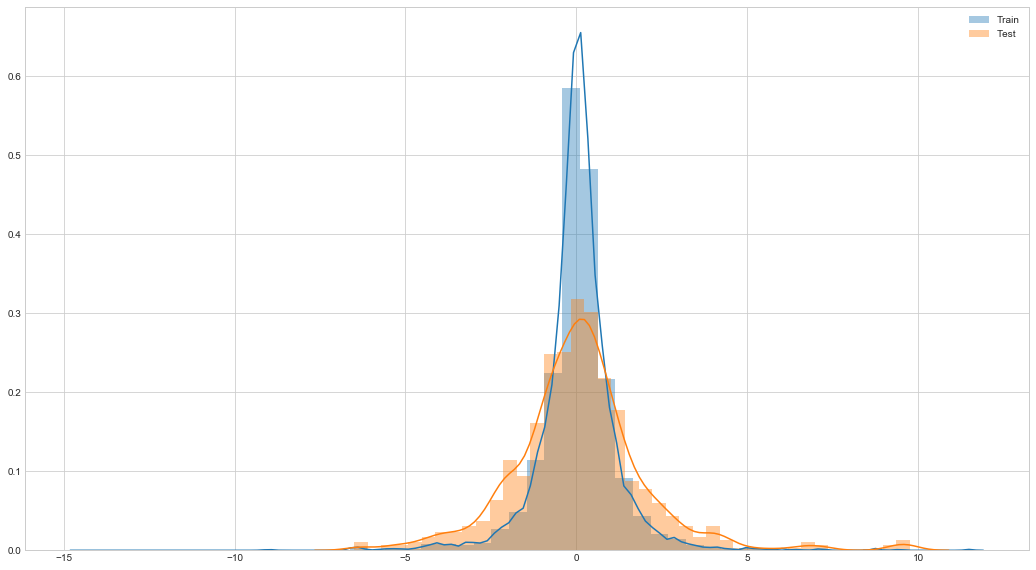

In [75]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (18,10)


# Label and title columns in datasets
BTC_LABEL_COL = 'label'
TEXT_COL = 'headline'

# Determine max post length
max_words_train = get_max_words(train_df[TEXT_COL].values)
max_words_test = get_max_words(test_df[TEXT_COL].values)
max_words = max(max_words_train, max_words_test)
print("Max number of words per post: {}".format(max_words))

# Plot distributions of labels
sns.set_style("whitegrid")
sns.distplot(train_df[BTC_LABEL_COL].values, label='Train')
sns.distplot(test_df[BTC_LABEL_COL].values, label='Test')
plt.legend()

In [10]:
# Split into x_train and y_train
print('\nGetting x_train, y_train, x_test, and y_test...')
(x_train, y_train_btc) = train_df[TEXT_COL].values, train_df[BTC_LABEL_COL]
(x_test, y_test_btc) = test_df[TEXT_COL].values, test_df[BTC_LABEL_COL]

# Print info about train and test
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")

Max number of words per post: 30

Getting x_train, y_train, x_test, and y_test...
3006 train sequences
752 test sequences
----------------------------


# Model setup (part 1/3)

In [18]:
# Set hyperparameters
max_features = 200000 # Num words in our vocabulary 
maxlen = max_words  # cut texts after this number of words
batch_size = 32  # Mini-batch size
epochs = 10 

# Train tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

# Vectorize each headline
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Update x_train and x_test to be 'sequences' of data
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)  

Pad sequences (samples x time)
x_train shape: (3006, 30)
x_test shape: (752, 30)


# Model setup (part 2/3)

In [19]:
# Build embedding layer using word2vec
EMBEDDING_FILE = "/Users/Connor/local_development/word2vec/embedding/GoogleNews-vectors-negative300.bin"
EMBEDDING_DIM = 300
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False) 

# Model setup (part 3/3)

In [54]:
# Get the actual embeddings
sequence_input = Input(shape=(maxlen,), dtype='int32')
embeddings = embedding_layer(sequence_input)

# Construct the model
X = Bidirectional(LSTM(128, return_sequences=False))(embeddings)
X = Dense(1)(X)

# BTC Model

In [55]:
# Define the BTC model
model = Model(inputs=sequence_input, 
                  outputs=X)

# Compile the BTC model
model.summary()
model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=['accuracy'])

# Select BTC labels for y
y_train = y_train_btc
y_test = y_test_btc


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           2016600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,456,153
Trainable params: 439,553
Non-trainable params: 2,016,600
_________________________________________________________________


In [58]:
# Run the BTC model
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(x_test, y_test))

Train on 3006 samples, validate on 752 samples
Epoch 1/10
3006/3006 [==============================] - 16s - loss: 0.4430 - acc: 0.0030 - val_loss: 4.4813 - val_acc: 0.0013
Epoch 2/10
3006/3006 [==============================] - 16s - loss: 0.3401 - acc: 0.0030 - val_loss: 4.5346 - val_acc: 0.0000e+00
Epoch 3/10
3006/3006 [==============================] - 16s - loss: 0.2842 - acc: 0.0033 - val_loss: 4.5292 - val_acc: 0.0013
Epoch 4/10
3006/3006 [==============================] - 16s - loss: 0.2205 - acc: 0.0033 - val_loss: 4.6290 - val_acc: 0.0013
Epoch 5/10
3006/3006 [==============================] - 16s - loss: 0.1653 - acc: 0.0037 - val_loss: 4.5619 - val_acc: 0.0013
Epoch 6/10
3006/3006 [==============================] - 16s - loss: 0.1271 - acc: 0.0040 - val_loss: 4.6039 - val_acc: 0.0013
Epoch 7/10
3006/3006 [==============================] - 17s - loss: 0.0970 - acc: 0.0040 - val_loss: 4.6780 - val_acc: 0.0013
Epoch 8/10
3006/3006 [==============================] - 16s - loss:

In [59]:
score, acc = model.evaluate(x_test, 
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

736/752 [============================>.] - ETA: 0sTest score: 4.6185991966978035
Test accuracy: 0.0013297872340425532


# Evaluate the results
    - Look at the distribution of the predicted results to see if the model makes large predictions
    - Perform some error analysis

In [60]:
predictions = model.predict(x_test)

In [61]:
pred_series = pd.Series(np.squeeze(predictions))
pred_series.describe()

count    752.000000
mean       0.012193
std        0.809852
min       -3.149573
25%       -0.489749
50%        0.051690
75%        0.543745
max        2.506731
dtype: float64

### First, print out text with corresponding percent changes greater than the cutoff

In [73]:
##### Set cutoff
cutoff = 2.0

test_text = list(test_df[TEXT_COL].values)
preds_list = list(np.squeeze(predictions))
labels_list = list(y_test)

for i, label in enumerate(labels_list):
    if abs(label) >= cutoff:
        print('------------------')
        print('Text:\n {}'.format(test_text[i]))
        print('\tActual:  {}'.format(labels_list[i]))
        count += 1
        
print("----------------------")
print("Count of examples greater than cutoff: {}".format(count))

------------------
Text:
 utility token icos are not equity, but sellers may still be giving up more value than they realize if they go down that path 
	Actual:  -2.112
------------------
Text:
 one of the most talked about technologies in development for bitcoin is the lightning network  but what does it do, and when might it be ready?
	Actual:  -2.112
------------------
Text:
 days before a major futures product launch, bitcoin suffered heavy losses saturday, a trend that so far appears to be continuing into sunday 
	Actual:  3.759
------------------
Text:
 the cboe's website became unavailable just as it launched its first bitcoin futures contracts on sunday 
	Actual:  3.946
------------------
Text:
 the first day of trading for cboe's bitcoin futures contracts is over and the day largely went according to plan, according to its ceo 
	Actual:  -2.1519999999999997
------------------
Text:
 sanity? you weren't going to find it in the crypto world in 2017 according to author david gera

### Now print out the text corresponding to predictions greater than the cutoff

In [74]:
count = 0

for i, pred in enumerate(preds_list):
    if abs(pred) >= cutoff:
        print('------------------')
        print('Text:\n {}'.format(test_text[i]))
        print('\tPrediction: {}'.format(pred))
        print('\tActual:  {}'.format(labels_list[i]))
        count += 1

print("----------------------")
print("Count of examples greater than cutoff: {}".format(count))

------------------
Text:
 south korea's nonghyup bank has joined the r3 distributed ledger consortium, saying it will launch a pilot blockchain project 
	Prediction: 2.0800957679748535
	Actual:  1.295
------------------
Text:
 the first day of trading for cboe's bitcoin futures contracts is over and the day largely went according to plan, according to its ceo 
	Prediction: -2.770845651626587
	Actual:  -2.1519999999999997
------------------
Text:
 former new zealand prime minister john key said he did not advise people to invest in bitcoin, as was stated in a post pretending to be the nz herald 
	Prediction: 2.220043897628784
	Actual:  0.614
------------------
Text:
 the impact of blockchain may be in the future, but entrepreneur and investor joe lubin is blazing a path today  here's his take on the industry today 
	Prediction: -2.0763468742370605
	Actual:  0.9259999999999999
------------------
Text:
 a research unit at the bank of england is reportedly investigating the introduction of